# 2020 TO 2023 US Congress members' stock transactions analysis

## Table of Contents
- [Introduction and Posing Questions](#intro)
- [Data Collection and Wrangling](#wrangle)
- [Exploratory Data Analysis](#eda)
   - [Statistics](#stats)
   - [Visualizations](#visuals)
- [Statistical Analysis](#statistical)
   - [Descriptive Analysis of Transactions Per Year and By Category](#desc)
   - [Chi-Square Test for Independence](#chi)

<a id="intro"></a>
## Introduction and Posing Questions

In this project, I will perform exploratory data analysis on the data provided by [House Stock Watcher](https://housestockwatcher.com/api) on the US Congress members' stock transactions for the years 2020, 2021, 2022, and 2023. The dataset includes various columns providing information on disclosure dates, transaction dates, asset details, transaction types, amounts, and other relevant attributes.
I seek to uncover patterns, trends, and potential conflicts of interest within the data. As a result, I have developed thought-provoking questions that can guide my analysis and uncover meaningful insights:

1. What are the primary motivations driving Congress members' stock transactions?
   - How do demographic factors such as party affiliation, and state influence trading activities?
   - Are there noticeable patterns in trading behavior based on transaction types such as purchases or sales?
   - Can we identify any correlation such as transaction amount and party affiliations?  
2. Are there observable trends in the frequency and volumes of stock transactions over multiple years?
   - Do certain years exhibit higher trading activities among Congress members, and if so, what factors might contribute to these fluctuations?
   - How does transaction volume vary across different sectors and industries, are there sectors that Congress members show a particular interest in?
   - Can we identify any anomalies or spikes in trading activities that warrant further investigation? 
3. Can we analyze the performance of Congress members' stock portfolios and identify any notable trends?
   - How do capital gain from stock transactions vary across different party affiliations?
   - Are there sectors that Congress members consistently realize higher capital gains, and what factors might explain these trends?
4. How can we cross-analyze trends between data dimensions to uncover deeper insights?
   - Are there correlations between transaction frequencies and demographic factors such as party affiliations?
   - How do sector-specific trends in stock transactions correlate with party affiliations?
   - Can we identify any systematic biases or patterns in trading activities that warrant further investigations?
     

<a id="wrangle"></a>
## Data Collection and Wrangling

The data utilized in this project is sourced from [House Stock Watcher](https://housestockwatcher.com), offering comprehensive stock transaction information of US Congress members spanning the years 2020 to 2023. Accessible via [House Stock Watcher API](https://house-stock-watcher-data.s3-us-west-2.amazonaws.com/data/all_transactions.json), this data is conveniently available in JSON format, facilitating integration and analysis.

In [1]:
# Import all the necessary packages
import requests
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, Style, init
import io
from scipy.stats import chi2_contingency

In [2]:
# Get the data from the API and change it into Pandas DataFrame
api_url = "https://house-stock-watcher-data.s3-us-west-2.amazonaws.com/data/all_transactions.json"
response = requests.get(api_url)
data = response.json()
df = pd.DataFrame(data)
df.head(3)

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,state,ptr_link,cap_gains_over_200_usd,industry,sector,party
0,2021,10/04/2021,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",Virginia Foxx,NC05,NC,https://disclosures-clerk.house.gov/public_dis...,False,Integrated oil Companies,Energy,Republican
1,2021,10/04/2021,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",Virginia Foxx,NC05,NC,https://disclosures-clerk.house.gov/public_dis...,False,Integrated oil Companies,Energy,Republican
2,2021,10/04/2021,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",Virginia Foxx,NC05,NC,https://disclosures-clerk.house.gov/public_dis...,False,Real Estate Investment Trusts,Real Estate,Republican


Now that we have the data loaded, it's observable from the above printout that the column formats are different even where the information is the same e.g. the date columns; `disclosure_date` and `transaction_date`. We will trim and clean the data to make things as simple as possible when we get to the actual exploration. Cleaning the data makes sure that the data formats are consistent while trimming focuses only on the part of the data we are interested in to make the exploration easier to work with.

In [3]:
# Select the columns relevant to the analysis
columns_to_drop = ["ticker","asset_description", "ptr_link", "district"]
stocks = df.drop(columns = columns_to_drop)
# Identify the indexes of the rows containing the problematic dates and drop them
index1 = stocks[stocks["transaction_date"] == "0009-06-09"].index
index2 = stocks[stocks["transaction_date"] == "0022-11-23"].index
index3 = stocks[stocks["transaction_date"] == "0021-08-02"].index
index4 = stocks[stocks["transaction_date"] == "0222-11-22"].index
index5 = stocks[stocks["transaction_date"] == "0023-01-11"].index
index6 = stocks[stocks["transaction_date"] == "0021-06-22"].index
index7 = stocks[stocks["transaction_date"] == "0201-06-22"].index
index8 = stocks[stocks["transaction_date"] == "0222-11-02"].index
problematic_indexes = list(index1) + list(index2) + list(index3) + list(index4) + list(index5) + list(index6) + list(index7) + list(index8)
stocks.drop(problematic_indexes, inplace = True)
# Replace the incorrect dates with correct ones using .loc
stocks.loc[stocks["transaction_date"] == "20222-08-09", "transaction_date"] = "2022-08-09"
stocks.loc[stocks["transaction_date"] == "20222-07-18", "transaction_date"] = "2022-07-18"
stocks.loc[stocks["transaction_date"] == "20222-11-16", "transaction_date"] = "2022-11-16"
stocks.loc[stocks["transaction_date"] == "20221-11-18", "transaction_date"] = "2021-11-18"
# Convert date columns to DateTime data type with specified formats
stocks["disclosure_date"] = pd.to_datetime(stocks["disclosure_date"], format = "%m/%d/%Y")
stocks["transaction_date"] = pd.to_datetime(stocks["transaction_date"], format = "%Y-%m-%d")
stocks.head(3)

,disclosure_year,disclosure_date,transaction_date,owner,type,amount,representative,state,cap_gains_over_200_usd,industry,sector,party
0,2021,2021-10-04,2021-09-27,joint,purchase,"$1,001 - $15,000",Virginia Foxx,NC,False,Integrated oil Companies,Energy,Republican
1,2021,2021-10-04,2021-09-13,joint,purchase,"$1,001 - $15,000",Virginia Foxx,NC,False,Integrated oil Companies,Energy,Republican
2,2021,2021-10-04,2021-09-10,joint,purchase,"$15,001 - $50,000",Virginia Foxx,NC,False,Real Estate Investment Trusts,Real Estate,Republican


In [4]:
# Display basic information about the dataset
buffer = io.StringIO()
stocks.info(buf=buffer)
info_str = buffer.getvalue()
print(Fore.RED + info_str + Style.RESET_ALL)

<class 'pandas.core.frame.DataFrame'>
Index: 17162 entries, 0 to 17169
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   disclosure_year         17162 non-null  int64         
 1   disclosure_date         17162 non-null  datetime64[ns]
 2   transaction_date        17162 non-null  datetime64[ns]
 3   owner                   10520 non-null  object        
 4   type                    17162 non-null  object        
 5   amount                  17162 non-null  object        
 6   representative          17162 non-null  object        
 7   state                   17162 non-null  object        
 8   cap_gains_over_200_usd  17162 non-null  bool          
 9   industry                12416 non-null  object        
 10  sector                  12416 non-null  object        
 11  party                   17077 non-null  object        
dtypes: bool(1), datetime64[ns](2), int64(1), object(8)


<a id="eda"></a>
## Exploratory Data Analysis

Now that we have the data wrangled, we're ready to start exploring the data. In this section, I will dive deep into our dataset to uncover patterns, trends, anomalies, and relationships that will provide valuable insights into our data. 
To begin the exploration, I will compute some descriptive statistics from the data, and then move into visualizations.

<a id="stats"></a>
### Statistics

First, let's compute some basic statistics from the data.

In [5]:
def compute_descriptive_statistics(df):
    total_transactions = len(df)

    highest_transaction_rep = df['representative'].value_counts().idxmax()
    highest_transaction_count = df['representative'].value_counts().max()

    highest_transaction_party = df['party'].value_counts().idxmax()
    highest_transaction_party_count = df['party'].value_counts().max()

    most_common_amount = df['amount'].mode()[0]
    most_common_amount_count = df['amount'].value_counts().max()
    
    most_common_sector = df['sector'].mode()[0]
    most_common_industry = df['industry'].mode()[0]
    most_common_transaction_type = df['type'].mode()[0]
    most_common_owner = df['owner'].mode()[0]
    most_common_state = df['state'].mode()[0]

    party_groups = stocks.groupby("party")
    party_stats = party_groups["amount"].describe()

    print("Findings:")
    print(Fore.GREEN + f"Total number of transactions: " + Fore.RED + f"{total_transactions}")
    print(Fore.GREEN + f"Representative with the highest number of transactions: " + Fore.RED +
          f"{highest_transaction_rep} ({highest_transaction_count} transactions)")
    print(Fore.GREEN + f"Party with the highest number of transactions: " + Fore.RED +
          f"{highest_transaction_party} ({highest_transaction_party_count} transactions)")
    print(Fore.GREEN + f"Most common transaction amount: " + Fore.RED +
          f"{most_common_amount} ({most_common_amount_count} transactions)")
    print(Fore.GREEN + f"Sector with the most transactions: " + Fore.RED + f"{most_common_sector}")
    print(Fore.GREEN + f"Industry with the most transactions: " + Fore.RED + f"{most_common_industry}")
    print(Fore.GREEN + f"Most common transaction type: " + Fore.RED + f"{most_common_transaction_type}")
    print(Fore.GREEN + f"Owner accounts that transacted most: " + Fore.RED + f"{most_common_owner}")
    print(Fore.GREEN + f"State with most transactions: " + Fore.RED + f"{most_common_state}")

    print(Fore.GREEN + f"Analyze transactions descriptive statistics for each party:" + "\n " + Fore.RED + f"{party_stats}")

compute_descriptive_statistics(stocks)

Findings:
Total number of transactions: 17162
Representative with the highest number of transactions: Josh Gottheimer (1453 transactions)
Party with the highest number of transactions: Democrat (10500 transactions)
Most common transaction amount: $1,001 - $15,000 (12079 transactions)
Sector with the most transactions: Technology
Industry with the most transactions: Computer Software: Prepackaged Software
Most common transaction type: purchase
Owner accounts that transacted most: joint
State with most transactions: CA
Analyze transactions descriptive statistics for each party:
              count unique                top  freq
party                                             
Democrat     10500     10   $1,001 - $15,000  8367
Jackson         14      3  $15,001 - $50,000    10
Libertarian      3      2   $1,001 - $15,000     2
Republican    6560     14   $1,001 - $15,000  3649


<a id="visuals"></a>
### Visualizations

I will further explore the US Congress members' stock data using visualizations created with Matplotlib and Seaborn libraries. I aim to gain deeper insights into the stock transaction and understand the patterns and trends from the period 2020 to 2023.

**1. Distribution of Transaction Amounts**

Let's start by visualizing the distribution of transaction amounts to understand the range and frequency of transactions:

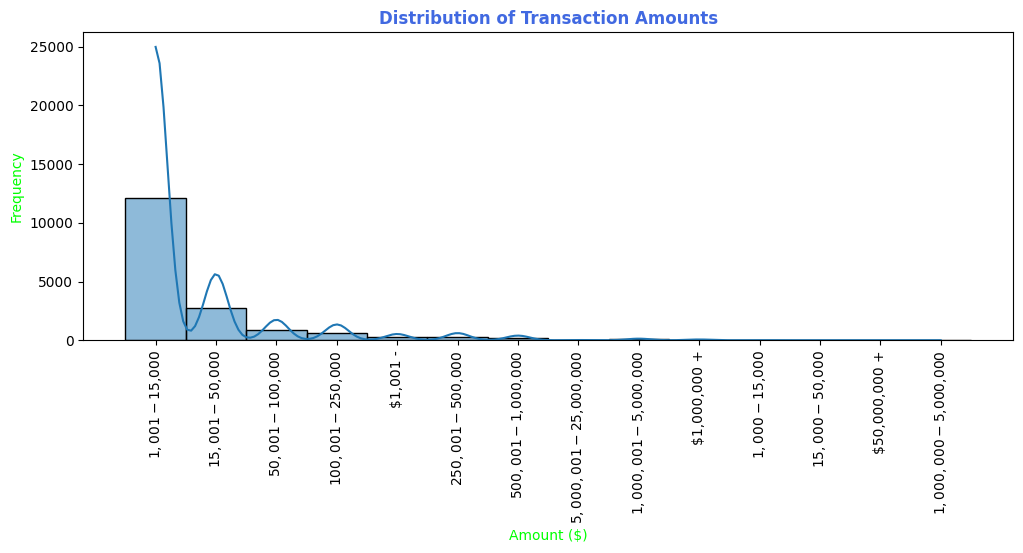

In [6]:
plt.figure(figsize=(12, 4))
sns.histplot(stocks['amount'], kde=True)
plt.title('Distribution of Transaction Amounts', color = 'royalblue', weight = 'bold')
plt.xlabel('Amount ($)', color = 'lime')
plt.ylabel('Frequency', color = 'lime')
plt.xticks(rotation=90)
plt.show()

The Histogram above shows that most of the US Congress members' stock transaction amounts were in the range of $1000-$15000. This aligns with our calculation above where we found that 12079 transactions out of 17162 were in this range.
The above plot has a kernel density estimate(KDE) which provides a smoothened representation of the underlying distribution of the transaction amounts. The data shape is right-skewed, indicating that most US Congress members' transactions have lower amounts, with a few transactions having higher amounts.

**2. Distribution of transaction amounts by Party Affiliations**

Let's now visualize the distribution of transaction amounts by party affiliations to see if there are any differences in trading behaviours among different political parties:

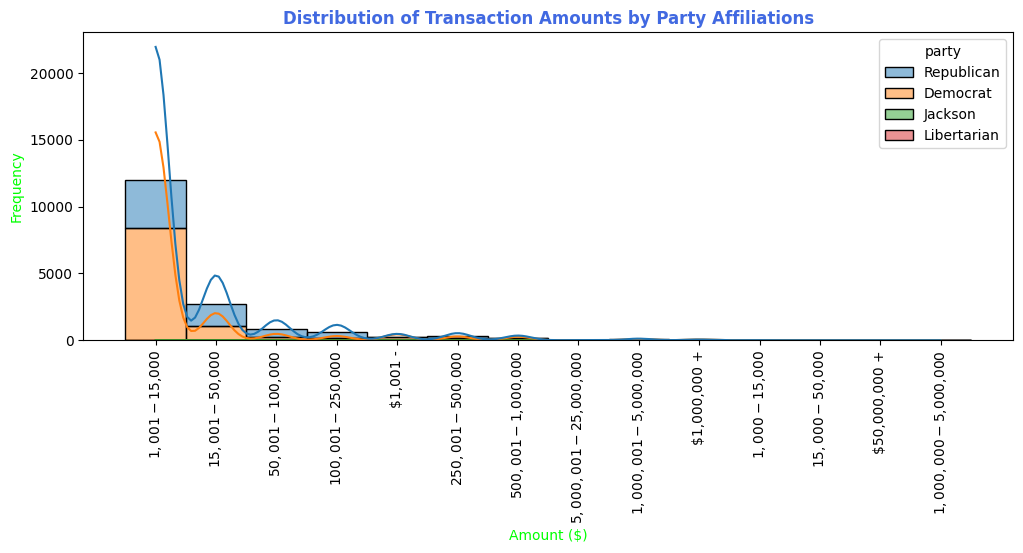

In [7]:
plt.figure(figsize=(12, 4))
sns.histplot(data=stocks, x='amount', hue='party', kde=True, multiple='stack')
plt.title('Distribution of Transaction Amounts by Party Affiliations', color='royalblue', weight='bold')
plt.xlabel('Amount ($)', color='lime')
plt.ylabel('Frequency', color='lime')
plt.xticks(rotation=90)
plt.show()

The plot above shows that most transactions were carried out by Democrats, which aligns with our calculations from above where the Democrats had 10500 transactions. However, as the transaction amount increases, we see slightly more transactions by the Republicans.

**3. Distribution of transactions across different sectors**

Here, I will explore the distribution of transactions across different sectors to identify which sectors are most frequently involved in stock transactions by Congress members.

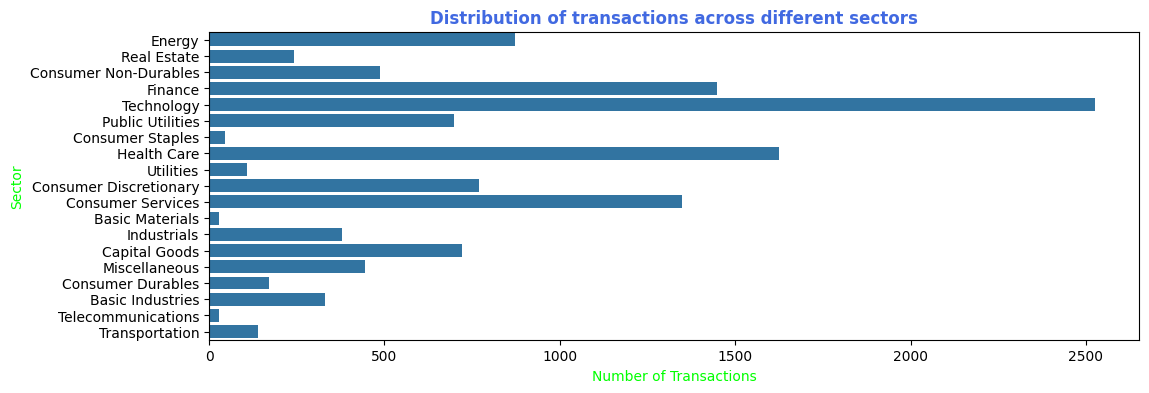

In [8]:
plt.figure(figsize=(12, 4))
sns.countplot(data=stocks, y='sector')
plt.title('Distribution of transactions across different sectors', color='royalblue', weight='bold')
plt.xlabel('Number of Transactions', color='lime')
plt.ylabel('Sector', color='lime')
plt.show()

From the above plot, we can see that the Technology sector had the most stock transactions by the Congress members. Other sectors like Health Care, Finance, Consumer Services, and Energy had higher transactions while sectors like Telecommunications, Basic Materials, and Consumer Staples had the least transactions.

**4. Distribution of transactions by year grouped by Party affiliations**

I will further explore the data to observe the variation in  transaction activity among different political parties over the years. 

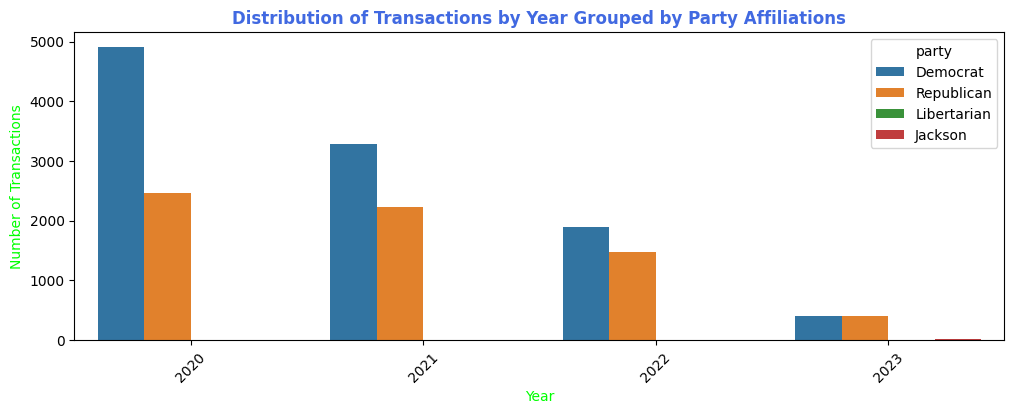

In [9]:
plt.figure(figsize=(12, 4))
sns.countplot(data=stocks, x='disclosure_year', hue='party')
plt.title('Distribution of Transactions by Year Grouped by Party Affiliations', color='royalblue', weight='bold')
plt.xlabel('Year', color='lime')
plt.ylabel('Number of Transactions', color='lime')
plt.xticks(rotation=45)
plt.show()

By examining the heights of the bars, we can see that the Democrats had more transactions across the years followed by the Republicans. Generally, the number of transactions decreased across the years with some parties such as the Jackson and Libertarian having little to no transactions across the years.

**5. Distributions of Transactions and Dislosures.**

Here, we utilize a time-series plot to examine the counts of transactions and disclosures recorded on each respective date, providing insights into the frequency and distribution of these events in the data.

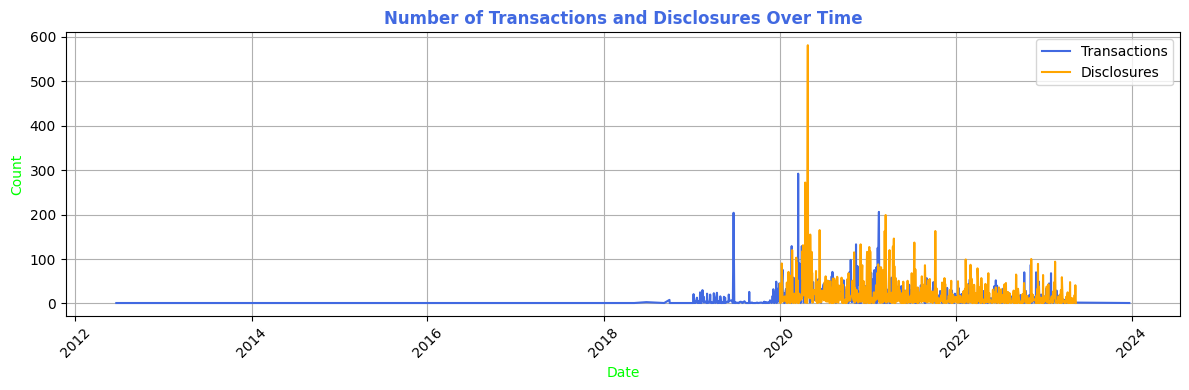

In [10]:
transactions_by_transaction_date = stocks.groupby('transaction_date').size().reset_index(name='transaction_count')
disclosures_by_disclosure_date = stocks.groupby('disclosure_date').size().reset_index(name='disclosure_count')

plt.figure(figsize=(12, 4))
plt.plot(transactions_by_transaction_date['transaction_date'], transactions_by_transaction_date['transaction_count'], color='royalblue', label='Transactions')
plt.plot(disclosures_by_disclosure_date['disclosure_date'], disclosures_by_disclosure_date['disclosure_count'], color='orange', label='Disclosures')
plt.title('Number of Transactions and Disclosures Over Time', color='royalblue', weight='bold')
plt.xlabel('Date', color='lime')
plt.ylabel('Count', color='lime')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Through the above visualization, we can see that the years 2012 to 2019 recorded some transactions with no disclosure until the year 2020 onwards, and the years 2019 to 2023 had the most transactions and disclosures.

<a id="#statistical"></a>
## Statistical Analysis

In this section, I will delve into a comprehensive statistical analysis of the Congress members' stock data to uncover meaningful insights, patterns, and relationships within the data. Specifically, I will conduct descriptive analysis of transactions per year based on a certain category, and also conduct Chi-square tests of independence as I aim to understand if there are any significant associations between categorical variables. This test is appropriate for our dataset because many of our variables are categorical.

<a id="desc"></a>
### Descriptive Analysis of Transactions Per Year and By Category

To further understand the data, I will describe the number of stock transactions per year and determine which party, industry, sector, amount, owner type, state, type, and if there were capital gains in each year.

**1. Stock transactions per year**

In [11]:
transactions_by_year = stocks['disclosure_year'].value_counts().to_dict()
print(Fore.GREEN + "\nNumber of Stock Transactions by Year:")
for year, count in transactions_by_year.items():
    print(Fore.RED + f"{year}: {count}")


Number of Stock Transactions by Year:
2020: 7379
2021: 5516
2022: 3354
2023: 913


The output above illustrates a decreasing trend in the number of stock transactions over the years:

- In 2020, there were 7379 stock transactions.
- By 2021, the number decreased to 5516, indicating a reduction from the previous year.
- This downward trend continued in 2022 with only 3354 transactions.
- Finally, in 2023, the number of transactions dropped further to 913, making a significant decrease compared to the preceding years.

This data suggests a continuous decline in stock transactions over the specified period, indicating  a possible decline in market activities by the US Congress members.

**2. Number of transactions by each party in each year**

In [12]:
transactions_by_year_party = stocks.groupby(['disclosure_year', 'party']).size().unstack(fill_value=0)
print(Fore.GREEN + "Number of Stock Transactions by Year and Party:")
print(Fore.RED + f"{transactions_by_year_party}")

Number of Stock Transactions by Year and Party:
party            Democrat  Jackson  Libertarian  Republican
disclosure_year                                            
2020                 4915        0            3        2461
2021                 3289        0            0        2227
2022                 1886        0            0        1468
2023                  410       14            0         404


The output is a calculation of the number of stock transactions categorized by the political affiliation of the involved parties over the specified period. 

- In 2020:
   - Democrats were involved in 4915 transactions.
   - Republicans participated in 2461 transactions, making it the second most active party.
   - Libertarians were involved in a few transactions, with only 3 recorded.
   - There were no recorded transactions involving the Jackson party.

- In 2021:
   - The total number of transactions decreased compared to the previous year.
   - Democrats were still the most active party, with 3289 transactions.
   - Republicans participated in 2227 transactions.
   - There were no transactions recorded for the Jackson and Libertarian parties.

- In 2022:
   - The overall number of transactions continued to decline.
   - Democrats remained the most active party, with 1886 transactions.
   - Republicans participated in 1468 transactions.
   - Again, no transactions were recorded for the Jackson and Libertarian parties.

- In 2023:
   - There was a significant drop in the total number of transactions.
   - Democrats remained in 410 transactions.
   - Republicans decreased to 404 transactions.
   - The Jackson party appeared in the data with 14 transactions, possibly indicating a new entry to the market.
   - The Libertarian party remained absent from the transactions.

The data suggests a decreasing trend in stock transactions over the years by the US Congress members, with the Democrats consistently being the most active party, followed by the Republicans. The minimal involvement of the Jackson and Libertarian parties throughout the years indicates a concentration of transactions with the Democrats and Republicans.

**3. Industry with most transactions in each year**

In [13]:
industries_by_year = stocks.groupby(['disclosure_year', 'industry']).size().reset_index(name='count')
industries_by_year = industries_by_year.loc[industries_by_year.groupby('disclosure_year')['count'].idxmax()]

print(Fore.GREEN + "Industries Traded Most Each Year:")
print(Fore.RED + f"{industries_by_year}")

Industries Traded Most Each Year:
     disclosure_year                                 industry  count
29              2020  Computer Software: Prepackaged Software    309
158             2021  Computer Software: Prepackaged Software    225
287             2022  Computer Software: Prepackaged Software    174
403             2023  Computer Software: Prepackaged Software     55


The output above outlines the industries that were traded most in each year, focusing on the top industry for each year:

- In 2020, the most traded industry was "Computer Software: Prepackaged Software", with a count of 309 trades.
- In 2021, "Computer Software: Prepackaged Software" remained the top traded industry although with a reduced count of 225 trades compared to the previous year.
- In 2022, the trend persisted with "Computer Software: Prepackaged Software" maintaining its position as the most traded industry, with a further decrease to 174 counts.
- In 2023, the dominance of "Computer Software: Prepackaged Software" persisted, although with a significant decrease in trading activities, dropping to just 55 trades.

The data suggests a consistent preference for trading in the computer software industry, particularly in prepackaged software over the period. However, there has been a notable decline in trading activity within the industry as the years progressed, indicating a potential shift in market dynamics.

**4. The sector with the most transactions in each year**

In [14]:
sectors_by_year = stocks.groupby(['disclosure_year', 'sector']).size().reset_index(name='count')
sectors_by_year = sectors_by_year.loc[sectors_by_year.groupby('disclosure_year')['count'].idxmax()]

print(Fore.GREEN + "Sectors Traded Most Each Year:")
print(Fore.RED + f"{sectors_by_year}")

Sectors Traded Most Each Year:
    disclosure_year      sector  count
15             2020  Technology    992
34             2021  Technology    860
53             2022  Technology    525
71             2023  Technology    148


The output above suggests a consistent preference for trading within the technology sector over the period, reflecting the importance and appeal of technology-related investments by Congress members. However, there are noticeable decline in trading activity within this sector as the years progressed indicating a potential shift in market dynamics.

**5. State with most transactions per year**

In [15]:
states_by_year = stocks.groupby(['disclosure_year', 'state']).size().reset_index(name='count')
states_by_year = states_by_year.loc[states_by_year.groupby('disclosure_year')['count'].idxmax()]

print(Fore.GREEN + "States Traded Most Each Year:")
print(Fore.RED + f"{states_by_year}")

States Traded Most Each Year:
     disclosure_year state  count
3               2020    CA   1366
44              2021    CA    789
103             2022    NC    508
142             2023    NJ    220


The output above presents the states that were traded most in each year, emphasizing the top state for each year:

- In 2020, California (CA) emerged as the most traded state, with 1366 trades recorded.
- Transitioning to 2021, California (CA) maintained its prominence as the most traded state, although trading activity decreased to 789 trades.
- Progressing to 2022, North Carolina (NC) took the lead as the most traded state, with 508 trades reported, indicating a shift from California's dominance in the previous years.
- Finally, in 2023, New Jersey (NJ) emerged as the most traded state, with 220 trades, suggesting further diversification in trading activity across different regions.

This output suggests a dynamic landscape in the trading activities of different states over the years, with shifts in prominence observed among California, North Carolina, and New Jersey. These shifts may reflect changes in economic conditions, regulatory environments, or investment opportunities within each state.

**6. Most amount category transacted per year**

In [16]:
amount_traded_most_by_year = stocks.groupby(['disclosure_year', 'amount']).size().reset_index(name='count')
amount_traded_most_by_year = amount_traded_most_by_year.loc[amount_traded_most_by_year.groupby('disclosure_year')['count'].idxmax()]

print(Fore.GREEN + "Amount Traded Most Each Year:")
print(Fore.RED + f"{amount_traded_most_by_year}")

Amount Traded Most Each Year:
    disclosure_year            amount  count
3              2020  $1,001 - $15,000   5318
16             2021  $1,001 - $15,000   3780
27             2022  $1,001 - $15,000   2341
37             2023  $1,001 - $15,000    640


The output above describes the most frequent transaction amount range for each year from the US Congress members dataset, we can see that the most common transaction amount range for all four years is "$1001 - $15000". However, the number of transactions within this range decreased significantly over time suggesting a downward trend in the number of transactions within this range, even though it remains the most frequent.

**7. Owner account type with most transactions per year**

In [17]:
owner_type_by_year = stocks.groupby(['disclosure_year', 'owner']).size().reset_index(name='count')
owner_type_by_year = owner_type_by_year.loc[owner_type_by_year.groupby('disclosure_year')['count'].idxmax()]

print(Fore.GREEN + "Owner Type Account Traded Most Each Year:")
print(Fore.RED + f"{owner_type_by_year}")

Owner Type Account Traded Most Each Year:
    disclosure_year  owner  count
2              2020  joint   2242
6              2021  joint   1576
9              2022  joint   1303
12             2023  joint    454


The output above describes the most frequent owner account used for stock transactions each year in the US Congress members dataset. We can see that for all four years, the most frequent owner-type account used for the transactions was "joint". However, the number of transactions using this account type has decreased over time. This suggests a downward trend in the number of transactions using joint accounts, even though it remains the most frequent type.

**8. Account types with most transactions per year**

In [18]:
account_type_by_year = stocks.groupby(['disclosure_year', 'type']).size().reset_index(name='count')
account_type_by_year = account_type_by_year.loc[account_type_by_year.groupby('disclosure_year')['count'].idxmax()]

print(Fore.GREEN + "Account Type Traded Most Each Year:")
print(Fore.RED + f"{account_type_by_year}")

Account Type Traded Most Each Year:
    disclosure_year      type  count
1              2020  purchase   3687
5              2021  purchase   3026
10             2022  purchase   1805
14             2023  purchase    431


The output above describes the most frequent account type used for stock transactions each year in the US Congress members dataset. For all four years, the most frequent account type used for the transactions was "purchase". However, the number of transactions using this account type has decreased. This suggests a downward trend in overall trading activities, with purchases being the most common type throughout the period.

**9. Did each year have a capital gain of $200 on transactions**

In [19]:
caps_gain_by_year = stocks.groupby(['disclosure_year', 'cap_gains_over_200_usd']).size().reset_index(name='count')
caps_gain_by_year = caps_gain_by_year.loc[caps_gain_by_year.groupby('disclosure_year')['count'].idxmax()]

print(Fore.GREEN + "Was There Capital Gains Over 200 USD In Each Year:")
print(Fore.RED + f"{caps_gain_by_year}")

Was There Capital Gains Over 200 USD In Each Year:
   disclosure_year  cap_gains_over_200_usd  count
0             2020                   False   6863
2             2021                   False   5069
4             2022                   False   3352
6             2023                   False    913


The above output describes the prevalence of capital gains exceeding 200 dollars in the US Congress members dataset for each year. It appears that there were no capital gains exceeding 200 dollars reported in the dataset in the four years. 

<a id="chi"></a>
### Chi-Square Test for Independence

We use the Chi-Square Test of Association to determine if there is a significant association between two categorical variables. This test helps us understand whether the distribution of one categorical variable differs based on the level of another categorical variable.

#### Hypotheses

- **Null Hypothesis (H₀)**: There is no association between the two categorical variables. This means the variables are independent of each other.
- **Alternate Hypothesis (H₁)**: There is an association between the two categorical variables. This means the variables are not independent of each other.

We will use the chi-square test statistic and p-value to determine whether to reject the null hypothesis in favor of the alternate hypothesis or to fail to reject the null hypothesis.

- The chi-square test statistic measures the difference between the observed frequencies and the expected frequencies under the assumption that the two variables are independent. A larger test statistic indicates a greater difference between the observed and expected frequencies, suggesting a stronger association between the variables.
- The p-value indicates the probability of observing a test statistic as extreme as, or more extreme than, the observed value, assuming the null hypothesis of independence is true. A very small p-value (typically less than 0.05) provides strong evidence against the null hypothesis, suggesting that the variables are not independent.


**1. Party Affiliation and Transaction Type**

- *Null Hypothesis (H₀)*: Party affiliation and transaction type are independent. The type of transaction does not depend on the party affiliation of the representative.
- *Alternate Hypothesis (H₁)*: Party affiliation and transaction type are not independent. The type of transaction depends on the party affiliation of the representative.

In [20]:
contingency_table = pd.crosstab(df['party'], df['type'])
chi2, p, dof, ex = chi2_contingency(contingency_table)

print(Fore.GREEN + "Chi-Square Test Statistic: " + Fore.RED + f"{chi2}")
print(Fore.GREEN + "P-value: " + Fore.RED + f"{p}")

Chi-Square Test Statistic: 464.7981530985886
P-value: 6.788257091967744e-92


The p-value above is extremely small, far below the common significance level of 0.05. This indicates strong evidence to reject the null hypothesis in favor of the alternate hypothesis and conclude that party affiliations influence the type of stock transactions made by US Congress members.

**2. Party Affiliation and Industry**

- *Null Hypothesis (H₀)*: There is no significant relationship between the political party affiliation of a representative and the industry of their stock transactions.
- *Alternate Hypothesis (H₁)*: There is a significant relationship between the political party affiliation of a representative and the industry of their stock transactions.

In [21]:
contingency_table = pd.crosstab(df['party'], df['industry'])
chi2, p, dof, ex = chi2_contingency(contingency_table)

print(Fore.GREEN + "Chi-Square Test Statistic: " + Fore.RED + f"{chi2}")
print(Fore.GREEN + "P-value: " + Fore.RED + f"{p}")

Chi-Square Test Statistic: 2592.1945131630755
P-value: 6.87359239318577e-310


Since the p-value (6.87359239318577e-310) is much smaller than 0.05, we reject the null hypothesis. This indicates that there is a significant relationship between the political party affiliation of the representatives and the industry of their stock transactions.

**3. Party Affiliation and Sector**

- *Null Hypothesis (H₀)*: There is no significant relationship between the political party affiliation of a representative and the sector of their stock transactions.
- *Alternate Hypothesis (H₁)*: There is a significant relationship between the political party affiliation of a representative and the sector of their stock transactions.

In [22]:
contingency_table = pd.crosstab(df['party'], df['sector'])
chi2, p, dof, ex = chi2_contingency(contingency_table)

print(Fore.GREEN + "Chi-Square Test Statistic: " + Fore.RED + f"{chi2}")
print(Fore.GREEN + "P-value: " + Fore.RED + f"{p}")

Chi-Square Test Statistic: 1143.865701825333
P-value: 5.226837286566197e-204


Since the p-value (5.226837286566197e-204) is much smaller than 0.05, we reject the null hypothesis. This indicates that there is a significant relationship between the political party affiliation of the representatives and the sector of their stock transactions. This result indicates that the sectors in which representatives engage in stock transactions are associated with their political party affiliations.

**4. Type of Transactions and Industry**

- *Null Hypothesis (H₀)*: There is no significant relationship between the type of stock transactions and the industry in which the transaction occurs.
- *Alternate Hypothesis (H₁)*: There is a significant relationship between the type of stock transactions and the industry in which the transaction occurs.

In [23]:
contingency_table = pd.crosstab(df['type'], df['industry'])
chi2, p, dof, ex = chi2_contingency(contingency_table)

print(Fore.GREEN + "Chi-Square Test Statistic: " + Fore.RED + f"{chi2}")
print(Fore.GREEN + "P-value: " + Fore.RED + f"{p}")

Chi-Square Test Statistic: 2359.6715353970176
P-value: 5.32952813905323e-220


The p-value of 5.32952813905323e-220 is extremely small, much smaller than the typical significance threshold of 0.05. Given that the p-value is far below 0.05, we reject the null hypothesis of independence and conclude that there is a significant relationship between the type of stock transaction and the industry.

**5. Type of Transactions and Sector**

- *Null Hypothesis (H₀)*: There is no significant relationship between the type of stock transactions and the sector where the transaction occurs.
- *Alternate Hypothesis (H₁)*: There is a significant relationship between the type of stock transactions and the sector where the transaction occurs.

In [24]:
contingency_table = pd.crosstab(df['type'], df['sector'])
chi2, p, dof, ex = chi2_contingency(contingency_table)

print(Fore.GREEN + "Chi-Square Test Statistic: " + Fore.RED + f"{chi2}")
print(Fore.GREEN + "P-value: " + Fore.RED + f"{p}")

Chi-Square Test Statistic: 693.4607958323763
P-value: 2.2307116399937045e-102


Given that the p-value is far below 0.05, we reject the null hypothesis of independence and conclude that there is a significant relationship between the type of stock transactions and the sector in which the transaction occurs.

**6. Industry and State**

- *Null Hypothesis (H₀)*: There is no significant relationship between the industry of stock transactions and the state of the representative.
- *Alternate Hypothesis (H₁)*: There is a significant relationship between the industry of stock transactions and the state of the representative.

In [25]:
contingency_table = pd.crosstab(df['industry'], df['state'])
chi2, p, dof, ex = chi2_contingency(contingency_table)

print(Fore.GREEN + "Chi-Square Test Statistic: " + Fore.RED + f"{chi2}")
print(Fore.GREEN + "P-value: " + Fore.RED + f"{p}")

Chi-Square Test Statistic: 37159.64865336398
P-value: 0.0


**7. Sector and State**

- *Null Hypothesis (H₀)*: There is no significant relationship between the sector of stock transactions and the state of the representative.
- *Alternate Hypothesis (H₁)*: There is a significant relationship between the sector of stock transactions and the state of the representative.

In [26]:
contingency_table = pd.crosstab(df['sector'], df['state'])
chi2, p, dof, ex = chi2_contingency(contingency_table)

print(Fore.GREEN + "Chi-Square Test Statistic: " + Fore.RED + f"{chi2}")
print(Fore.GREEN + "P-value: " + Fore.RED + f"{p}")

Chi-Square Test Statistic: 8675.060924769956
P-value: 0.0


**8. Transaction Type and State**

- *Null Hypothesis (H₀)*: There is no significant relationship between the type of stock transactions and the state of the representatives.
- *Alternate Hypothesis (H₁)*: There is a significant relationship between the type of stock transactions and the state of the representatives.

In [27]:
contingency_table = pd.crosstab(df['type'], df['state'])
chi2, p, dof, ex = chi2_contingency(contingency_table)

print(Fore.GREEN + "Chi-Square Test Statistic: " + Fore.RED + f"{chi2}")
print(Fore.GREEN + "P-value: " + Fore.RED + f"{p}")

Chi-Square Test Statistic: 3359.8032503492514
P-value: 0.0
